In [206]:
"""Module providing access to creating namedtuple structures"""
import collections
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import tensorflow as tf
import tensorflow_probability as tfp

# Preamble

In [207]:
sns.set_theme()

In [208]:
# Aliasing
DTYPE = tf.float64

tfd = tfp.distributions

tf_map = tf.nest.map_structure

# User defined types

In [209]:
# User defined types
ParameterTuple = collections.namedtuple(
    'ParameterTuple', 'loc')

ParameterTupleV2 = collections.namedtuple(
    'ParameterTuple', 'loc scale')

McmcResult = collections.namedtuple(
    'McmcResult', 'is_accepted current_state current_state_log_prob')

# Data simulation 

In [210]:
# Data creation - toy example

toy_param = {'loc': tf.constant(3.5, dtype=DTYPE),
             'scale': tf.constant(1.34, dtype=DTYPE)
             }

toy_gaussian = tfp.distributions.Normal(
    loc=toy_param['loc'],
    scale=toy_param['scale']).sample(
    1000, seed=20060420)

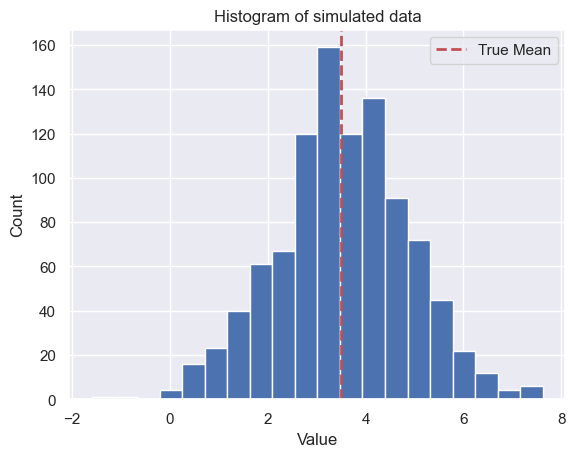

In [211]:
fig, ax = plt.subplots()
pd.DataFrame(toy_gaussian).hist(bins = 20, ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Value')
ax.set_title('Histogram of simulated data')
ax.axvline(x = 3.5, color='r', linestyle='--', label='True Mean',linewidth =2)
ax.legend()

# Target log prob function 

In [212]:
def toy_log_ll(data):
    """log-likelihood for a normal distribution

    Args:
        data (float64): sample of a noraml distribution
    """
    def target_log_prob(parameters):
        # prior distribution
        prior_dist = tfp.distributions.Normal(
            loc=tf.constant(0., DTYPE), 
            scale=tf.constant(10., DTYPE)).log_prob(parameters)

        # likelihood
        log_ll_eval = tfp.distributions.Normal(
            loc=parameters, scale=tf.constant(1.34, dtype=DTYPE, name = 'known_mean')).log_prob(data)
        return tf.reduce_sum(log_ll_eval) + tf.reduce_sum(prior_dist)

    return target_log_prob

In [213]:
def generate_prior_distributions(loc_prior, scale_prior): 
    """
    Generate prior distributions for location and scale parameters of a 
    Gaussian distribution. 
    
    Args: 
        loc_prior (tfp.distributions): prior for the location/mean
        scale_prior (tfp.distributions): prior for the scale/standard deviation
        
    Returns: 
        prior_distribution (fn): 
    """
    def prior_distribution(loc_value, scale_value):
        """
        Evaluate the prior distributions for each of the parameters 
        
        Args: 
            loc_value (float64): value to evaluate the prior at 
            scale_value (float64): value to evaluate the prior at 
        """        
        return loc_prior.log_prob(loc_value) + scale_prior.log_prob(scale_value)
    
    return prior_distribution

In [214]:
def generate_gaussian_likelihood(data):
    """
    Generate log-likelihood for a Gaussian distribution with unknown mean 
    and unkown standard deviation

    Args: 
        data (float64): observations from a Gaussian distribution 

    Returns:
        gaussian_likelihood (fn):
    """
    def gaussian_likelihood(parameters):
        loc, scale = parameters
        log_ll_eval = tfp.distributions.Normal(loc=loc,
                                               scale=scale).log_prob(data)

        return -tf.reduce_sum(log_ll_eval)
    return gaussian_likelihood

In [215]:
# partial functions fixing each parameter so they can be mapped to their own kernels
def toy_log_ll_v2(data):
    """
    Returns the log-likelihood function of a normal distribution for a given sample.

    Args:
        data: A float64 Tensor representing a sample from a normal distribution.

    Returns:
        A Tensor representing the log-likelihood of the sample.

    Raises:
    ValueError: If the data is not a float64 Tensor.
    """

    def target_log_prob(loc, scale):
        """
        Parameters (ParameterTupleV2): tuple defining the mean AND variance

        Returns:
          The log-likelihood of the sample under the given parameters.
        """
        # prior distribution
        prior_dist = tfp.distributions.Normal(
            loc=tf.constant(0., DTYPE),
            scale=tf.constant(10., DTYPE)).log_prob(loc) + \
                tfp.distributions.Exponential(rate=tf.constant(2, DTYPE)).log_prob(scale)
    
        # likelihood
        log_ll_eval = tfp.distributions.Normal(
            loc=loc, scale=scale).log_prob(data)
        return tf.reduce_sum(log_ll_eval) + tf.reduce_sum(prior_dist)

    return target_log_prob

In [216]:
# partial function evaluation to get a partial target log prob
tlp_fixed_scale_moving_loc = functools.partial(toy_log_ll_v2(data=toy_gaussian),
                                               scale=tf.constant(1.34, dtype=DTYPE, name='fixed_variance'))
tlp_fixed_loc_moving_scale = functools.partial(toy_log_ll_v2(data=toy_gaussian),
                                               loc=tf.constant(2.0, dtype=DTYPE, name='fixed_mean'))

In [217]:
# eg. using the partial functions
tlp_fixed_scale_moving_loc(tf.constant(2.0, dtype=DTYPE, name='moving_loc')) == tlp_fixed_loc_moving_scale(
    scale=tf.constant(1.34, dtype=DTYPE, name='moving_scale'))

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [218]:
toy_log_ll(toy_gaussian)(tf.constant(2.0, dtype=DTYPE,name='moving_loc'))

<tf.Tensor: shape=(), dtype=float64, numpy=-2367.1258732116958>

In [219]:
def generate_partial_target_log_prob(target_log_prob_fn, **kwargs):
    """
    Reimplementation of the partial function evaluation in the functools package. 
    A target_log_prob_fn and a namedTuple of all the arguments the target_log_prob_fn
    takes. The inner closure takes a name-value pairing for the part of the 
    target_log_prob_fn which will be the subject of inference in the step. In other 
    words, it performs the Gibbs step of conditioning the target_log_prob_fn on *all* 
    model variables with the exception of one which corresponds to the accompaying
    TransitionKernel (this will perform a one_step evaluation on the target variable)

    Args:
        target_log_prob_fn: the target log-probability of the model
        **kwargs: a namedTuple of parameters and values. This is to be the current_state 
            of the chain
        
    Return:
        partial_target_log_prob_fn:
    """
    def partial_target_log_prob_fn(**target_kwargs):
        """
        Create an conditional probability function which takes only one arguement. Namely,
        the variable that is the scope of the current Gibbs step of the 
        Metropolis-within-Gibbs algorithm.
        
        Return: 
            target_log_prob_fn(**partial_kwargs, **kwargs): an evaluation of the target_log_prob_fn 
                with all variables fixed
        """
        return target_log_prob_fn(**target_kwargs, **kwargs)

    return partial_target_log_prob_fn

## Reformat the TLP without Functools

In [220]:
def generate_gaussian_log_likelihood(data):

    def guassian_log_likelihood_fn(loc, scale):

        # evaluate the log likelihood for each data point 
        gaussian_log_prob = tfd.Normal(loc = loc, scale = scale).log_prob(data)

        return tf.reduce_sum(gaussian_log_prob)

    return guassian_log_likelihood_fn

In [221]:
def generate_prior_distributions():
    
    def prior_distributions_fn(loc, scale):
        # mean
        mean_prior = tfd.Normal(loc = tf.constant(0, dtype=DTYPE), scale = tf.constant(10., dtype=DTYPE)).log_prob(loc)
        # std dev 
        std_dev_prior = tfd.Exponential(tf.constant(2, dtype=DTYPE)).log_prob(scale)

        return tf.reduce_sum([mean_prior, std_dev_prior])

    return prior_distributions_fn

In [222]:
def generate_target_fn(log_likelihood_fn, prior_fn):

    def target_log_prob_fn(loc, scale):
        return tf.reduce_sum([log_likelihood_fn(loc, scale), 
                              prior_fn(loc, scale)])
        
    return target_log_prob_fn

In [223]:
# define building blocks 
log_prob_fn= generate_gaussian_log_likelihood(toy_gaussian)

prior_fn = generate_prior_distributions()

# combine them
target_log_prob_fn = generate_target_fn(log_prob_fn, prior_fn)

In [224]:
target_log_prob_fn(**toy_param)

<tf.Tensor: shape=(), dtype=float64, numpy=-1720.1847021674541>

In [225]:
partial_tlp_scale_target = generate_partial_target_log_prob(
    target_log_prob_fn, loc=tf.constant(3.5, dtype=DTYPE))

In [226]:
partial_tlp_scale_target(scale= tf.constant(1.34, dtype=DTYPE))

<tf.Tensor: shape=(), dtype=float64, numpy=-1720.1847021674541>

# Proposal distribution creation

In [227]:
def generate_gaussian_proposal(scale):
    """Instantiate a Gaussian proposal for an MCMC kernel 

    Args:
        scale (float64): the scale of the proposal distribution. 
        Must contain only positive values. 

    Returns:
        fn: proposal function with a fixed scale parameter. The
        function takes in the current chain state and a seed, 
        and returns a sample of size 1 matching the current 
        state dimensions
    """
    scale = tf.cast(scale, DTYPE)
    def gaussian_proposal_fn(current_state, seed):
        """Propose next state in an MCMC chain given a current
        state and a seed 

        Args:
            current_state (float64): vector of values of the 
            current chain state
            seed (int): PRNG seed

        Returns:
            float64: suggested next state for the chain
        """
        loc = tf.cast(current_state, DTYPE)
        isotropic_normal = tfp.distributions.Normal(
            loc=loc, scale=scale)
        return isotropic_normal.sample(seed=seed)
    
    def log_acceptance_correction_fn(current_state, proposed_state):
        return tf.constant(0., dtype = DTYPE)
    
    return gaussian_proposal_fn, log_acceptance_correction_fn

In [228]:
def generate_gamma_proposal(distribution_parameters):
    # indepedence sampler? - Yes. 
    """_summary_

    Args:
        distribution_parameters (float64): list of parameters for the gamma distirbution, namely the [concentration, rate] values

    Returns:
        proposed_next_state (f ): function which proposed the next step in the chain
        log_acceptance_correction (fn): function which outputs the acceptance ratio correction
    """
    # initialize the distribution
    proposal_distribution = tfp.distributions.Gamma(
        concentration=distribution_parameters[0],       # alpha
        rate=distribution_parameters[1])                # beta

    def proposed_next_state_fn(current_state, seed):
        return proposal_distribution.sample(
            sample_shape=tf.shape(current_state),
            seed=seed)

    def log_acceptance_correct_fn(current_state, proposed_state):
        # q(x | x')
        backward_correction = proposal_distribution.log_prob(
            value=current_state, name='backward_correction')

        # q(x' | x)
        forward_correction = proposal_distribution.log_prob(
            value=proposed_state, name='forward_correction')

        return backward_correction - forward_correction

    return proposed_next_state, log_acceptance_correct_fn

In [229]:
def generate_exponential_proposal(rate_parameter):
    """
    Create an exponential(r) proposal function for an MCMC algorithm. This is a 
    proposal function for an indepedence sampler so it will not depend on the 
    current chain state (with the exception of using the current state to propose
    values with the same shape)

    Args:
        rate_parameter (float64): rate parameter for the exponential distribution 

    Returns:
        proposed_next_state_fn (fn): 
        log_acceptance_correct_fn (fn):
    """
    proposal_distribution = tfp.distributions.Exponential(
        rate=rate_parameter, name="Exp-r-proposal")

    def proposed_next_state_fn(current_state, seed):
        return proposal_distribution.sample(sample_shape=tf.shape(current_state),
                                            seed=seed)

    def log_acceptance_correct_fn(current_state, proposed_state):
        # q(x | x')
        backward_correction = proposal_distribution.log_prob(
            value=current_state, name='backward_correction')

        # q(x' | x)
        forward_correction = proposal_distribution.log_prob(
            value=proposed_state, name='forward_correction')

        return backward_correction - forward_correction
    
    return proposed_next_state_fn, log_acceptance_correct_fn

In [230]:
def generate_uniform_proposal(distribution_parameters):
    """
    Create an Uniform(x - l, x + h) proposal function for an MCMC algorithm. This is a 
    proposal function for a Metropolish sampler so it will depend on the 
    current chain state (both in current state and to propose values with the same shape)

    Args:
        distribution_parameters (tuple float64): low, high parameters for the Uniform distribution 

    Returns:
        proposed_next_state_fn (fn): 
        log_acceptance_correct_fn (fn):
    """
    proposal_distribution = tfp.distributions.Uniform(low = distribution_parameters[0],
                                                      high= distribution_parameters[1],
                                                      name='Uniform-proposal')
    
    def proposed_next_state_fn(current_state, seed):
        return current_state + proposal_distribution.sample(seed=seed)
    
    def log_acceptance_correct_fn(current_state, proposed_state):
        # q(x | x')
        backward_correction = proposal_distribution.log_prob(
            value=current_state, name='backward_correction')

        # q(x' | x)
        forward_correction = proposal_distribution.log_prob(
            value=proposed_state, name='forward_correction')

        return backward_correction - forward_correction
    
    return proposed_next_state_fn, log_acceptance_correct_fn
    

# RWMH kernel 

In [315]:
# inference algorithms

# random walk metropolis hastings
def random_walk_metropolis_hastings_kernel(target_log_prob_fn, initial_state, proposal_distribution):
    """Runs one step of the Metropolis-Hastings algorithm.
    Proposal distribution is symmetric meaning there is
    no need for any adjustments to the log-acceptance ratio

    Args:
        target_log_prob_fn (fn): a *partial* evaluation of the
        model target log prob function which moves *only* the
        parameters of interest of the inference block 
        proposal_scale (float64): vector of the proposal
        distribution scales for the parameters of interest
        of the inference block

    Returns:
        current_state (float64): state of the chain after the step
        has been run
        kernel_result (RWMHResult): tracing tuple of information
        from the algorithm

    """
    propose_next_step_fn, log_acceptance_correction_fn = proposal_distribution

    def bootstrap_result(current_state):
        """Returns an object with the same type as returned by `one_step`.

        Args:
          init_state: `Tensor` or Python `list` of `Tensor`s representing the
            initial state(s) of the Markov chain(s).

        Returns:
          kernel_results: A (possibly nested) `tuple`, `namedtuple` or `list` of
            `Tensor`s representing internal calculations made within this function.
        """
        kernel_output = McmcResult(
            is_accepted=tf.ones_like(
                target_log_prob_fn(**current_state),
                dtype=tf.bool),
            current_state=current_state,
            current_state_log_prob=target_log_prob_fn(**current_state))
        return ParameterTuple(kernel_output)

    @tf.function(jit_compile=True)
    def random_walk_metropolis_hastings_one_step(
            current_state, previous_kernel_result, seed):
        """_summary_

        Args:
            current_state (ParameterTuple): _description_
            previous_kernel_result (RWMHResult): _description_
            seed (int): PRNG seed

        Returns:
            _type_: _description_
        """
        # preliminary book keeping and caching
        current_state_log_prob = previous_kernel_result[-1].current_state_log_prob
        variable_name, variable_value = **current_state
        
        # Step 1: Seed handling - Can we do this outside?
        proposal_seed, accept_seed = tfp.random.split_seed(
            seed, n=2, salt="McmcResult")

        # Step 2: Propose next step
        
        next_state = propose_next_step_fn(current_state=variable_value,
                                           seed=proposal_seed)
        print(f'Proposed move: {next_state}')
        # Step 3: Evaluate the target-log-prob of the proposal
        # IMPORTANT: inputted target_log_prob_fn is a partial evaluation
        # of the model target_log_prob in the main function
        # The function works on a named argument basis so we need to
        # unpack a dictionary of the current state. This conflicts wiht the proposed since
        # it just wants a value for the parameter of interest (sol: change ALL functions 
        # to a named argument basis)

        next_target_log_prob = target_log_prob_fn(current_state)
        # I am here, pick up later :) 
        # Step 4: Compute log-accept ratio
        log_accept_ratio = next_target_log_prob - \
            current_state_log_prob

        # Step 5: Check accept/reject
        log_uniform = tf.math.log(tfp.distributions.Uniform(
            high=tf.constant(1., dtype=DTYPE)).sample(seed=accept_seed))

        is_accepted = log_uniform < log_accept_ratio

        # Step 6: Update the current_state and kernel_results
        current_state = tf.cond(
            is_accepted, lambda: next_state, lambda: current_state)
        current_state_log_prob = tf.cond(
            is_accepted, lambda: next_target_log_prob,
            lambda: current_state_log_prob)

        kernel_results = McmcResult(
            is_accepted=is_accepted,
            current_state=current_state,
            current_state_log_prob=current_state_log_prob
        )
        return current_state, ParameterTuple(kernel_results)

    return bootstrap_result(initial_state), random_walk_metropolis_hastings_one_step

# Independance Kernel

In [232]:
# independence sampler
def independence_sampler_kernel(target_log_prob_fn, initial_state, proposal_distribution):
    # processing the proposal distribution
    propose_next_step_fn, log_acceptance_correction_fn = proposal_distribution

    # bootstrap results function
    def bootstrap_result(current_state):
        """Returns an object with the same type as returned by `one_step`.

        Args:
          init_state: `Tensor` or Python `list` of `Tensor`s representing the
            initial state(s) of the Markov chain(s).

        Returns:
          kernel_results: A (possibly nested) `tuple`, `namedtuple` or `list` of
            `Tensor`s representing internal calculations made within this function.
        """
        kernel_output = McmcResult(
            is_accepted=tf.ones_like(
                # PROBLEM: requires the parameter name IF the partial function is NOT
                # the first in the list that it was specified. Positional arguments issue
                target_log_prob_fn(scale=current_state),
                dtype=tf.bool),
            current_state=current_state,
            current_state_log_prob=target_log_prob_fn(scale=current_state))
        return ParameterTuple(kernel_output)

    # one step function
    @tf.function(jit_compile=True)
    def independence_sampler_one_step(
            current_state, previous_kernel_result, seed):

        # Step 0: pick up the previous state log-prob
        current_state_log_prob = previous_kernel_result[-1].current_state_log_prob

        # Step 1: Seed handling - Can we do this outside?
        proposal_seed, accept_seed = tfp.random.split_seed(
            seed, n=2, salt="McmcResult")

        # Step 2: Propose next step
        next_state = propose_next_step_fn(current_state=current_state,
                                          seed=proposal_seed)
        
        # Step 3: Evaluate the target-log-prob of the proposal
        # Note: inputted target_log_prob_fn is a partial evaluation
        # of the model target_log_prob in the main function

        next_target_log_prob = target_log_prob_fn(scale=next_state)
        log_acceptance_correction = log_acceptance_correction_fn(current_state=current_state,
                                                                 proposed_state=next_state)
        # Step 4: Compute log-accept ratio
        log_accept_ratio = tf.math.reduce_sum(
            [next_target_log_prob, -current_state_log_prob, log_acceptance_correction])

        # Step 5: Check accept/reject
        log_uniform = tf.math.log(tfp.distributions.Uniform(
            high=tf.constant(1., dtype=DTYPE)).sample(seed=accept_seed))

        is_accepted = log_uniform < log_accept_ratio

        # Step 6: Update the current_state and kernel_results
        current_state = tf.cond(
            is_accepted, lambda: next_state, lambda: current_state)
        current_state_log_prob = tf.cond(
            is_accepted, lambda: next_target_log_prob,
            lambda: current_state_log_prob)

        kernel_results = McmcResult(
            is_accepted=is_accepted,
            current_state=current_state,
            current_state_log_prob=current_state_log_prob
        )
        return current_state, ParameterTuple(kernel_results)

    return bootstrap_result(initial_state), independence_sampler_one_step

# Sampling function

In [233]:
def sample_chain(
        current_state, previous_kernel_results, kernel, seed, num_results=15):
    """Implements Markov chain Monte Carlo via repeated `TransitionKernel` steps

    This acts as a generic loop wrapper which takes in a kernel and reapplies it
    to the current state. The previous state is an instance of the bootstrap
    result and is used to cache computations done in the previous iteration 
    of the algorithm. 

    Args:
        current_state (ParameterTuple): `Tensor` or Python `list` of 
        `Tensor`s representing the current state(s) of the Markov chain(s).
        previous_kernel_results (RWMHResults): A `Tensor` or a nested 
        collection of `Tensor`s representing internal calculations made
        within the previous call to this function (or as 
        returned by `bootstrap_results`) 
        kernel (fn): an *instance* of a transition kernel which implements 
        a one step fn 
        num_results (int, optional): number of iterations to run the MCMC 
        algorithm for. Defaults to 15.

    Returns:
        parameters_samples: A nest collection of 'Tensor's containing the
        values of the MCMC chain
        kernel_trace: A nested collection of 'Tensor's containing cached
        calculations of the MCMC algorithm for each iteration (used in 
        diagnostics and tuning)
    """
    global kernel_trace
    # Create MCMC tracers
    parameter_samples = tf_map(
        lambda x: tf.TensorArray(dtype=x.dtype, size=num_results),
        current_state)

    kernel_trace = tf_map(
        lambda x: tf.TensorArray(dtype=x.dtype, size=num_results),
        previous_kernel_results)

    def cond(iterator,
             _2,
             _3,
             _4,
             _5,
             _6):
        """_summary_

        Args:
            iterator (_type_): _description_

        Returns:
            _type_: _description_
        """
        return iterator < num_results

    def body(iterator,
             current_state,
             previous_kernel_result,
             parameter_samples,
             mcmc_results,
             seed):
        """_summary_

        Args:
            iterator (_type_): _description_
            current_state (_type_): _description_
            previous_kernel_result (_type_): _description_
            parameter_samples (_type_): _description_
            mcmc_results (_type_): _description_
            seed (_type_): _description_

        Returns:
            _type_: _description_
        """
        global kernel_trace
        # Seed handling
        this_seed, next_seed = tfp.random.split_seed(seed, n=2, salt="body")

        # Perform one step of the chain
        next_state, next_kernel_result = kernel(
            current_state=current_state,
            previous_kernel_result=previous_kernel_result,
            seed=this_seed
        )

        parameter_samples = tf_map(
            lambda x, a: a.write(iterator, x),
            next_state, parameter_samples)

        # Track the outcome - KERNEL STATE(S)
        kernel_trace = tf_map(lambda x, a: a.write(iterator, x),
                              next_kernel_result, kernel_trace)

        return (iterator + 1,
                next_state,
                next_kernel_result,
                parameter_samples,
                kernel_trace,
                next_seed)

    # Run chain(s)
    (_1,
     _2,
     _3,
     parameter_samples,
     kernel_trace,
     _4) = tf.while_loop(cond=cond,
                         body=body,
                         loop_vars=(0,
                                    current_state,
                                    previous_kernel_results,
                                    parameter_samples,
                                    kernel_trace,
                                    seed))

    # formatting
    parameter_samples = tf_map(
        lambda x: x.stack(), parameter_samples)

    kernel_trace = tf_map(lambda x: x.stack(),  kernel_trace)

    return parameter_samples, kernel_trace

# RWMH-MCMC Implementation 

In [234]:
kernel_output_structure, kernel_fn = random_walk_metropolis_hastings_kernel(
    target_log_prob_fn=tlp_fixed_scale_moving_loc,
    initial_state=tf.constant(5.0, dtype=DTYPE),
    proposal_distribution= generate_gaussian_proposal(scale =0.26331088295714156))

State: 5.0
Help on partial object:

class partial(builtins.object)
 |  partial(func, *args, **keywords) - new function with partial application
 |  of the given arguments and keywords.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __delattr__(self, name, /)
 |      Implement delattr(self, name).
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __reduce__(...)
 |      Helper for pickle.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __setattr__(self, name, value, /)
 |      Implement setattr(self, name, value).
 |  
 |  __setstate__(...)
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  __class_getitem__(...) from builtins.type
 |      See PEP 585
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) fro

In [235]:
N = 10_000

chains, results = sample_chain(
    current_state=tf.constant(5.0, dtype=DTYPE),
    previous_kernel_results=kernel_output_structure,
    kernel=kernel_fn,
    seed=20220807,
    num_results=N)

# RWMH-MCMC Diagnostics

In [236]:
# acceptance rate: 
print(f'MCMC sampler acceptance rate: {100*np.sum(results[0].is_accepted)/N}%')

MCMC sampler acceptance rate: 20.38%


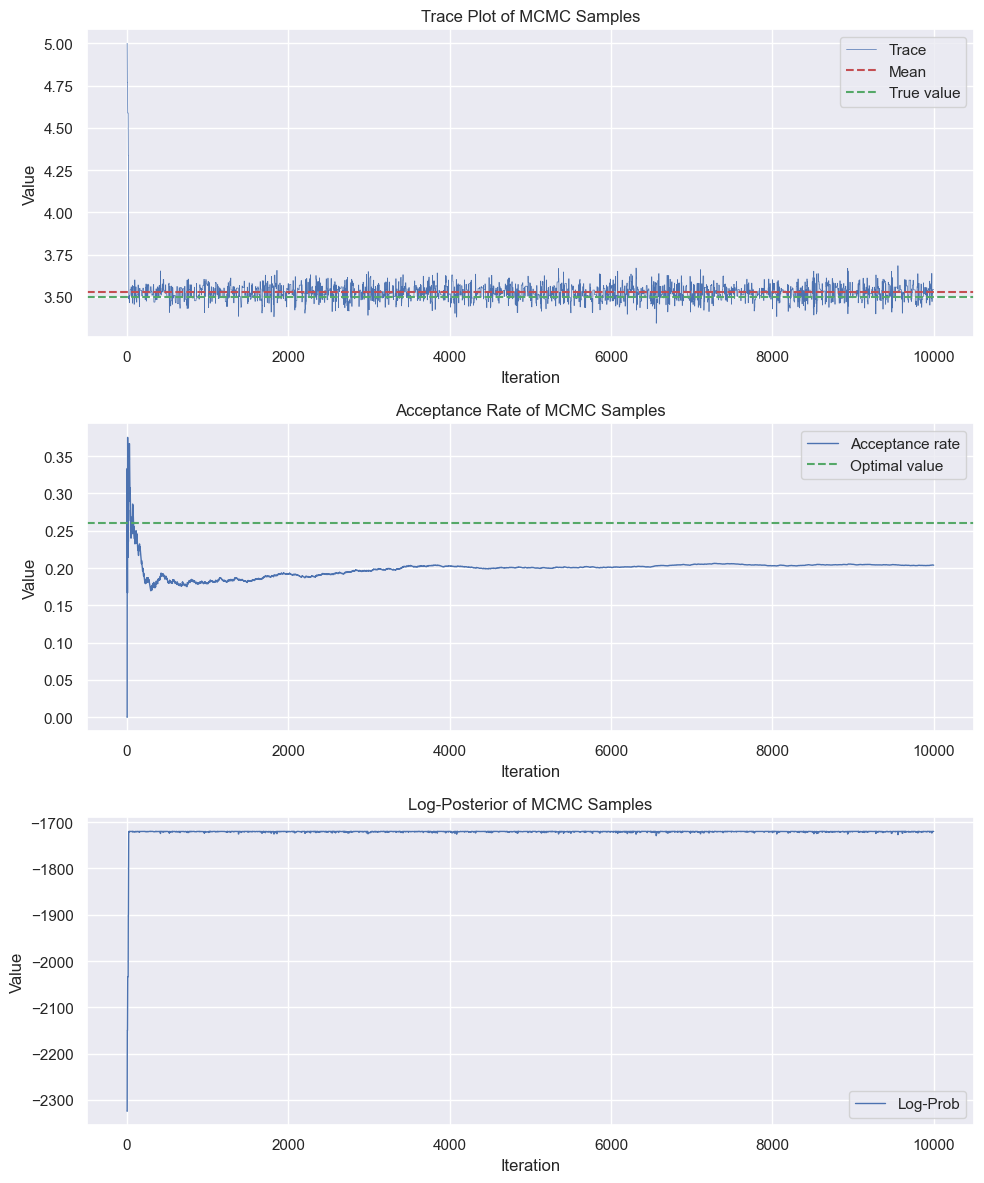

In [237]:
# Create a figure with subplots
fig, axs = plt.subplots(3,1, figsize=(10, 12))

# Trace plot
axs[0].plot(chains, linestyle='-', color='b', label='Trace', linewidth = 0.5)
axs[0].axhline(y=np.mean(chains), color='r', linestyle='--', label='Mean',linewidth = 1.5)
axs[0].axhline(y=3.5, color='g', linestyle='--', label='True value', linewidth = 1.5)
# Add labels and title
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value')
axs[0].set_title('Trace Plot of MCMC Samples')
axs[0].legend()

# Acceptance rate plot 
axs[1].plot(np.cumsum(results[0].is_accepted)/range(1, N+1), linestyle='-', color='b', label='Acceptance rate', linewidth = 1)
axs[1].axhline(y=0.26, color='g', linestyle='--', label='Optimal value', linewidth = 1.5)
# Add labels and title
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value')
axs[1].set_title('Acceptance Rate of MCMC Samples')
axs[1].legend()

# Log posterior plot
axs[2].plot(results[0].current_state_log_prob, linestyle='-', color='b', label='Log-Prob', linewidth = 1)
# Add labels and title
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Value')
axs[2].set_title('Log-Posterior of MCMC Samples')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [238]:
pd.DataFrame(chains, columns= ['Value']).describe()

,Value
count,10000.000000
mean,3.528765
std,0.064081
min,3.344501
25%,3.498323
50%,3.526466
75%,3.556069
max,5.000000


In [239]:
# adaptive MCMC proposal variance 
(2.38**2)*np.std(chains) 

0.3629621245285566

# IS-MCMC Implementation

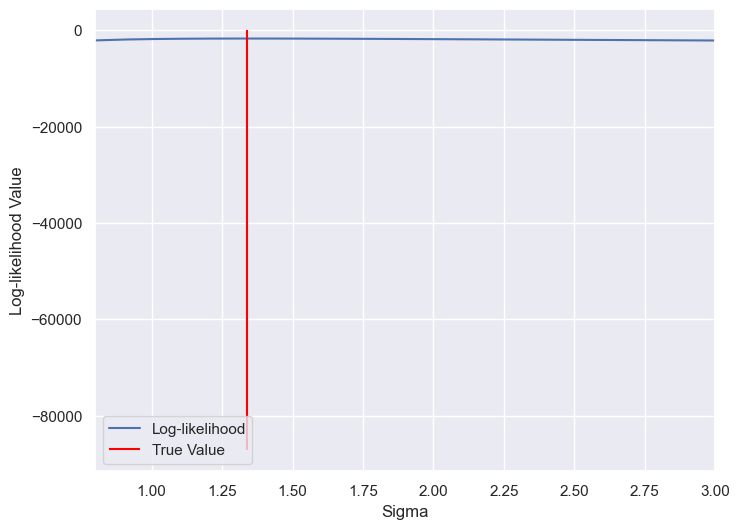

In [240]:
x = np.linspace(start=0, stop=10, num=100)
y = tf.map_fn(fn=lambda x: partial_tlp_scale_target(scale=x), elems=x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Log-likelihood')
plt.xlim(0.8, 3)
plt.vlines(x=1.34, label='True Value', ymax=0, ymin=np.min(y[1:]), color='red')
plt.xlabel('Sigma')
plt.ylabel('Log-likelihood Value')
plt.legend()

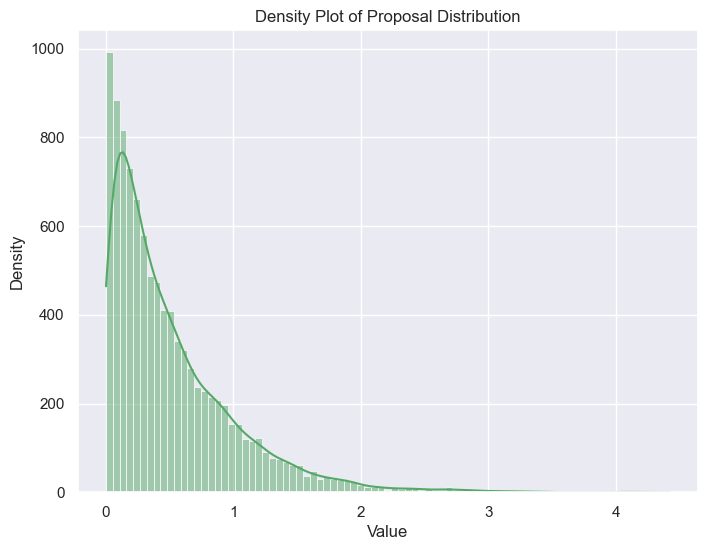

In [241]:
# Simulate 10,000 points from a gamma distribution with shape=2 and scale=1
proposal_samples = np.random.exponential(scale = 0.5, size = 10000)

# Create a density plot
plt.figure(figsize=(8, 6))
sns.histplot(proposal_samples, kde=True, color='g', label='Density Plot')
plt.title('Density Plot of Proposal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)

# Show the plot
plt.show()

In [242]:
IS_kernel_output_structure, IS_kernel_fn = independence_sampler_kernel(target_log_prob_fn=partial_tlp_scale_target,
                                                                       initial_state=tf.constant(
                                                                           5, dtype=DTYPE),
                                                                      proposal_distribution= generate_gaussian_proposal(scale = tf.constant(.14, dtype=DTYPE))
                                                                      )

In [243]:
### N = 10_0
N = 10_000
chains, results = sample_chain(
    current_state=tf.constant(1, dtype=DTYPE),
    previous_kernel_results=IS_kernel_output_structure,
    kernel=IS_kernel_fn,
    seed=20220807,
    num_results=N)

# IS-MCMC Diagnostics

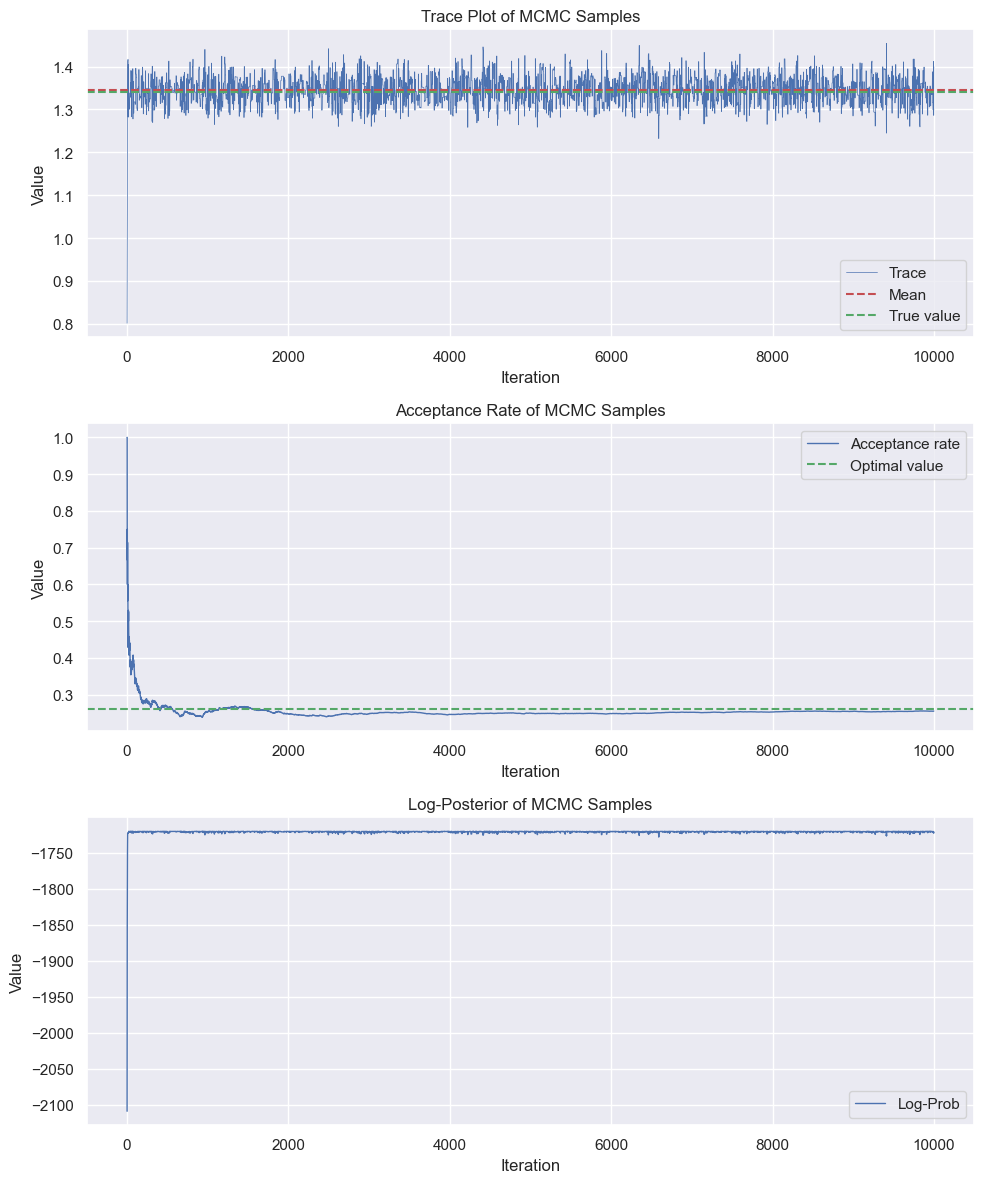

In [244]:
# Create a figure with subplots
fig, axs = plt.subplots(3,1, figsize=(10, 12))

# Trace plot
axs[0].plot(chains, linestyle='-', color='b', label='Trace', linewidth = 0.5)
axs[0].axhline(y=np.mean(chains), color='r', linestyle='--', label='Mean',linewidth = 1.5)
axs[0].axhline(y=tf.constant(1.34, dtype=DTYPE), color='g', linestyle='--', label='True value', linewidth = 1.5)
# Add labels and title
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value')
axs[0].set_title('Trace Plot of MCMC Samples')
axs[0].legend()

# Acceptance rate plot 
axs[1].plot(np.cumsum(results[0].is_accepted)/range(1, N+1), linestyle='-', color='b', label='Acceptance rate', linewidth = 1)
axs[1].axhline(y=0.26, color='g', linestyle='--', label='Optimal value', linewidth = 1.5)
# Add labels and title
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value')
axs[1].set_title('Acceptance Rate of MCMC Samples')
axs[1].legend()

# Log posterior plot
axs[2].plot(results[0].current_state_log_prob, linestyle='-', color='b', label='Log-Prob', linewidth = 1)
# Add labels and title
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Value')
axs[2].set_title('Log-Posterior of MCMC Samples')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [245]:
pd.DataFrame(chains, columns= ['Value']).describe()

,Value
count,10000.000000
mean,1.345932
std,0.031462
min,0.801316
25%,1.325990
50%,1.346194
75%,1.367545
max,1.453972


In [246]:
# acceptance rate: 
print(f'MCMC sampler acceptance rate: {100*np.sum(results[0].is_accepted)/N}%')

MCMC sampler acceptance rate: 25.56%


In [247]:
# adaptive MCMC proposal variance 
(2.38**2)*np.std(chains) 

0.17820186414510683

# Chained kernels

In [248]:
ParameterTupleV2.__doc__

'ParameterTuple(loc, scale)'

In [266]:
# global scoped MCMC components
MwG_initial_state = ParameterTupleV2(loc=tf.constant(5.0, dtype=DTYPE),
                                     scale=tf.constant(5.0, dtype=DTYPE))
MwG_initial_state = MwG_initial_state._asdict()

In [259]:
MwG_tlp = target_log_prob_fn # split into partial TLP within the one step fn 

In [267]:
MwG_tlp(**MwG_initial_state)

<tf.Tensor: shape=(), dtype=float64, numpy=-2620.5677697949122>

In [287]:
for key, value in MwG_initial_state.items():
    print(f'Conditional Var:{key}, Value: {value}')
    foo = generate_partial_target_log_prob(target_log_prob_fn=MwG_tlp, **{key: value})
    print(f'Output: {foo}')
    target_values = {k:v for k,v in MwG_initial_state.items() if k not in key}
    print(f'Target values: {target_values}')
    print(f'Likelihood: {foo(**target_values)}')
     

Conditional Var:loc, Value: 5.0
Output: <function generate_partial_target_log_prob.<locals>.partial_target_log_prob_fn at 0x7f869c0663a0>
Target values: {'scale': <tf.Tensor: shape=(), dtype=float64, numpy=5.0>}
Likelihood: -2620.5677697949122
Conditional Var:scale, Value: 5.0
Output: <function generate_partial_target_log_prob.<locals>.partial_target_log_prob_fn at 0x7f86a57d90d0>
Target values: {'loc': <tf.Tensor: shape=(), dtype=float64, numpy=5.0>}
Likelihood: -2620.5677697949122


In [316]:
# Gibbs sampler - iterate over each parameter and sample from the conditional distribution

for variable, current_value in MwG_initial_state.items():
    # identify the target variable: 
    print('Target variable: ', variable)
    
    # pick up the variables to condition on - can be more than 1
    conditional_variables = {k:v for k,v in MwG_initial_state.items() if k not in variable}
    
    # create the conditional likelihood function
    conditional_tlp = generate_partial_target_log_prob(target_log_prob_fn=MwG_tlp, **conditional_variables)
    #print(f'Output: {conditional_tlp}')
    
    # example evaluation of the conditional likelihood
    #print(f'Likelihood: {conditional_tlp(**{variable: current_value})}')
    
    # create the kernel
    kernel_output_structure, kernel_fn = random_walk_metropolis_hastings_kernel(target_log_prob_fn=conditional_tlp,
                                                    initial_state={variable:current_value},
                                                    proposal_distribution=generate_gaussian_proposal(scale=0.5))
    print(f'Current kernel signature: {kernel_output_structure}')
    print(f'Current kernel one step fn: {kernel_fn}')
    
    # envoke the kernel for one step 
    
    kernel_fn(current_state=current_value, 
              previous_kernel_result=kernel_output_structure, 
              seed=20220807)

Target variable:  loc
Current kernel signature: ParameterTuple(loc=McmcResult(is_accepted=<tf.Tensor: shape=(), dtype=bool, numpy=True>, current_state={'loc': <tf.Tensor: shape=(), dtype=float64, numpy=5.0>}, current_state_log_prob=<tf.Tensor: shape=(), dtype=float64, numpy=-2620.5677697949122>))
Current kernel one step fn: <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function object at 0x7f86896ecd90>
Proposed move: Tensor("Normal/sample/Reshape:0", shape=(), dtype=float64)


TypeError: in user code:

    File "/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_75500/3610679338.py", line 72, in random_walk_metropolis_hastings_one_step  *
        next_target_log_prob = target_log_prob_fn(next_state)

    TypeError: tf__partial_target_log_prob_fn() takes 0 positional arguments but 1 was given


In [252]:
MwG_propoals = ParameterTupleV2(loc=generate_gaussian_proposal(scale=0.26331088295714156),
                                scale=generate_gaussian_proposal(scale=tf.constant(.14, dtype=DTYPE)))

In [253]:
MwG_subkernel_generator = ParameterTupleV2(loc=random_walk_metropolis_hastings_kernel, 
                                           scale= random_walk_metropolis_hastings_kernel)

In [254]:
MwG_tlp

<function __main__.generate_target_fn.<locals>.target_log_prob_fn(loc, scale)>

In [255]:
generate_partial_target_log_prob(
    target_log_prob_fn, loc=MwG_initial_state.loc)(scale=MwG_initial_state.scale)

<tf.Tensor: shape=(), dtype=float64, numpy=-2620.5677697949122>

In [256]:
MwG_initial_state._fields

('loc', 'scale')

In [257]:
# one_step implementation for the Metropolis-within-Gibbs algorithm

# 0. create subkernel 1 
loc_tlp = generate_partial_target_log_prob(MwG_tlp, MwG_initial_state)


TypeError: generate_partial_target_log_prob() takes 1 positional argument but 2 were given

In [ ]:
loc_tlp(**needed_arg)

<function __main__.generate_partial_target_log_prob.<locals>.partial_target_log_prob_fn.<locals>.<lambda>(eval)>

In [ ]:
needed_arg = {'loc': MwG_initial_state[0]}

In [ ]:
random_walk_metropolis_hastings_kernel(target_log_prob_fn=loc_tlp,
                                       initial_state= **needed_arg,
                                       proposal_distribution=MwG_propoals.loc)

SyntaxError: invalid syntax (4290429790.py, line 2)

In [ ]:
def generate_MwG_kernel(target_log_prob_fn, initial_state,
                        proposal_distributions, subkernels):
    """
    Create a Metropolis within Gibbs sampling kernel 

    Args:
        target_log_prob_fn (fn):
        initial_state (ParameterTupleV2):
        proposal_distribution (ParameterTupleV2):
        subkernels (ParameterTupleV2r):

    Returns:
        bootstrap_result:

        MwG_one_step:

    """
    # initial set up:
    # instances of the kernel generators (these are fn)
    generate_loc_kernel, generate_scale_kernel = subkernels
    
    loc
    print(generate_loc_kernel)
    
    # instances of the proposal distribution
    loc_proposal, scale_proposal = proposal_distributions

    def bootstrap_result(current_state):
        # structure to write results to for the mean targeting kernel
        mean_inference_results = McmcResult(
            is_accepted=tf.ones_like(
                target_log_prob_fn(*current_state),
                dtype=tf.bool),
            current_state=getattr(current_state, 'mean'),
            current_state_log_prob=target_log_prob_fn(*current_state))

        # structure to write results to for the scale targeting kernel
        scale_inference_results = McmcResult(
            is_accepted=tf.ones_like(
                target_log_prob_fn(*current_state),
                dtype=tf.bool),
            current_state=getattr(current_state, 'mean'),
            current_state_log_prob=target_log_prob_fn(*current_state))

        MwG_McmcResults = ParameterTupleV2(mean=mean_inference_results,
                                           scale=scale_inference_results)

        return MwG_McmcResults

    def MwG_one_step(current_state, previous_kernel_result, seed=1):
        
        loc_seed, scale_seed = tfp.random.split_seed(seed, n = len(current_state), salt = 'MwG')
        
        # 1. initialize the mean kernel with the current state 
        loc_tlp = generate_partial_target_log_prob(target_log_prob_fn, 
                                                   scale=getattr(MwG_initial_state, 'scale'))
        
        loc_kernel = generate_loc_kernel(target_log_prob_fn = loc_tlp, 
                                         initial_state = getattr(current_state, 'mean'),
                                         proposal_distribution =  loc_proposal)
        
        # 1. execute mean kernel 
        loc_kernel(current_state = getattr(current_state))
        print(f'Fist kernel: {loc_kernel}')
        
        # 2. initialize the scale kernel with the current state 
        # 3. execute scale kernel
        
        print(f'Second kernel: {None}')
        # 3. Combine together to return the next state 
    
        return None

    return bootstrap_result(initial_state), MwG_one_step